<a href="https://colab.research.google.com/github/MoAKgit/Debluring-Based-on-GAN/blob/master/Copy_of_Warwick_Deeplab_512.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q "pytorch-lightning<2.0.0"
import pytorch_lightning as pl

print(pl.__version__)


!rm -rf Warwick_QU_Dataset_512.zip
!rm -rf Warwick_QU_Dataset_512
!rm -rf lightning_logs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.6 MB/s eta 0:00:00
1.9.5


In [2]:
!pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=65610d7e0a9285e2da4233b57b08bdda5e4b910ee624e187f1aab3c9101ecde5
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=32377242ee8e41c2acd6a44a6cf4e

In [3]:
! gdown --id 1hBywB14KQ_B4kboovO_FYVd-RosWruky
! unzip  Warwick_QU_Dataset_512.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1hBywB14KQ_B4kboovO_FYVd-RosWruky
To: /content/Warwick_QU_Dataset_512.zip
100% 11.4M/11.4M [00:00<00:00, 12.5MB/s]
Archive:  Warwick_QU_Dataset_512.zip
   creating: Warwick_QU_Dataset_512/
   creating: Warwick_QU_Dataset_512/test/
  inflating: Warwick_QU_Dataset_512/test/testA_11.jpg  
  inflating: Warwick_QU_Dataset_512/test/testA_11_anno.png  
  inflating: Warwick_QU_Dataset_512/test/testA_12.jpg  
  inflating: Warwick_QU_Dataset_512/test/testA_12_anno.png  
  inflating: Warwick_QU_Dataset_512/test/testA_13.jpg  
  inflating: Warwick_QU_Dataset_512/test/testA_13_anno.png  
  inflating: Warwick_QU_Dataset_512/test/testA_14.jpg  
  inflating: Warwick_QU_Dataset_512/test/testA_14_anno.png  
  inflating: Warwick_QU_Dataset_5

In [4]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transform
import albumentations as albu

In [5]:
#  In SemanticSegmentationDataset we applied data augmentation, normalizxation 
#  Using  albumentations library
class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, stage = 'visual'):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir

        self.classes_csv_file = os.path.join(self.root_dir, "_classes.csv")
        with open(self.classes_csv_file, 'r') as fid:
            data = [l.split(',') for i,l in enumerate(fid) if i !=0]
        self.id2label = {x[0]:x[1] for x in data}
        
        image_file_names = [f for f in os.listdir(self.root_dir) if '.jpg' in f]
        mask_file_names = [f for f in os.listdir(self.root_dir) if '.png' in f]
        
        self.images = sorted(image_file_names)
        self.masks = sorted(mask_file_names)

        mean = [0.485, 0.456, 0.406]  ###   mean for  normalization 
        std = [0.229, 0.224, 0.225]   ###   std for normalization 

        if stage == "train":

          self.preprocess = albu.Compose([albu.Normalize(mean = mean,std = std),
                                          albu.HorizontalFlip(p=0.5),   ##  Horizentally rotation
                                          albu.RandomCrop(256, 256, p = 1)]) ##  HRandom cropping with size(128,128)
          
        elif (stage == "test") or (stage == 'valid'):

          self.preprocess = albu.Compose([albu.Normalize(mean = mean,std  = std)])
        
        else:
          self.preprocess = albu.Compose()
          

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        image = Image.open(os.path.join(self.root_dir, self.images[idx]))
        mask = Image.open(os.path.join(self.root_dir, self.masks[idx]))

        image = np.array(image, dtype=np.float32)
        mask = np.array(mask, dtype=np.float32)
        # mask = np.expand_dims(mask, 0)



        augmented  = self.preprocess(image=image, mask=mask)

        image = augmented['image']
        mask = augmented['mask']
        

        dic = {}
        dic['image'] = image.transpose(2, 0, 1)
        dic['mask'] = mask = np.expand_dims(mask, 0)

        return dic

In [6]:
train_dataset = SemanticSegmentationDataset("/content/Warwick_QU_Dataset_512/train/",  'train')
valid_dataset = SemanticSegmentationDataset("/content/Warwick_QU_Dataset_512/valid/", 'valid')
test_dataset = SemanticSegmentationDataset("/content/Warwick_QU_Dataset_512/test/",  'test')

batch_size = 8
num_workers = 2
n_cpu = os.cpu_count()
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=n_cpu)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=n_cpu)

image = train_dataset[0]["image"]
mask = train_dataset[0]["mask"]
print(image.shape)
print(mask.shape)

(3, 256, 256)
(1, 256, 256)


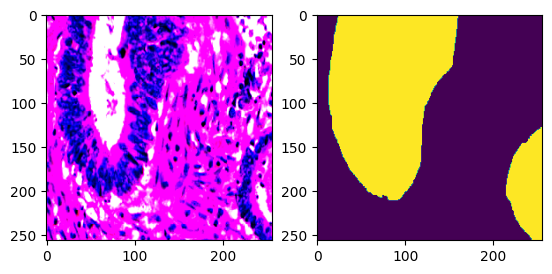

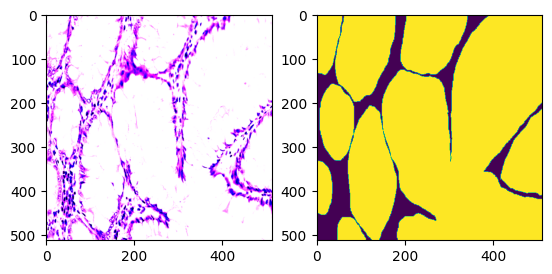

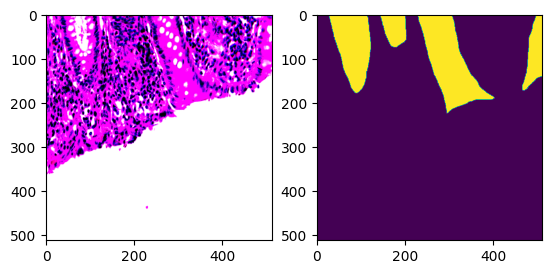

In [7]:
# lets look at some samples
from matplotlib import pyplot as plt
sample = train_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

from matplotlib import pyplot as plt
sample = valid_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

from matplotlib import pyplot as plt
sample = test_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

In [8]:
import os
import torch
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import pytorch_lightning as pl

class PedestrianModel(pl.LightningModule):

    def __init__(self, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()

        # self.model = smp.create_model(
        #     arch, 
        #     encoder_name=encoder_name,
        #     in_channels=in_channels, 
        #     classes=out_classes, **kwargs
        # )

        self.model = smp.DeepLabV3Plus(
                              encoder_name = encoder_name, 
                              encoder_weights = 'imagenet',
                              classes = out_classes,
                              activation=None )
        # smp.Unet('resnet34', encoder_weights='imagenet')



        self.train_dl = train_dataloader
        self.val_dl = valid_dataloader
        self.test_dl = test_dataloader
        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):

        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])
        loss = torch.stack([x["loss"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        avg_loss = [x["loss"] for x in outputs]
        avg_loss = torch.stack(avg_loss).mean()
        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
            f"{stage}_loss": avg_loss,
        }
        
        self.log_dict(metrics, prog_bar=True)
        return metrics

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def train_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.00005)
        
    def train_dataloader(self):
        return self.train_dl
    
    def val_dataloader(self):
        return self.val_dl
    
    def test_dataloader(self):
        return self.test_dl

In [10]:
# model = PedestrianModel("FPN", "resnet34", in_channels=3, out_classes=1)
# model = PedestrianModel("Unet", "resnet34", in_channels=3, out_classes=1)
# model = PedestrianModel("PSPNet", "resnet34", in_channels=3, out_classes=1)
model = PedestrianModel( "resnet50", in_channels=3, out_classes=1)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 65.9MB/s]


In [23]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
checkpoint_callback = ModelCheckpoint(save_top_k=1,
                                      filename='Warwick_DeeplabV3_512-{epoch:02d}-{step:02d}',
                                      dirpath='/content/ckpt/',
                                      monitor="valid_loss")

early_stop_callback = EarlyStopping(
    monitor="valid_loss", 
    min_delta=0.00, 
    patience=10, 
    verbose=False, 
    mode="min",
)

In [24]:

trainer = pl.Trainer(
    accelerator="auto", 
    max_epochs=1,
    callbacks=[early_stop_callback, checkpoint_callback],
    val_check_interval=len(train_dataloader),
)
# trainer = pl.Trainer(
#     accelerator="auto", 
#     max_epochs=100,
# )



INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [25]:
trainer.fit(
    model, 
    train_dataloaders=train_dataloader, 
    val_dataloaders=valid_dataloader,
)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /content/ckpt exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type          | Params
------------------------------------------
0 | model   | DeepLabV3Plus | 26.7 M
1 | loss_fn | DiceLoss      | 0     
------------------------------------------
26.7 M    Trainable params
0         Non-trainable params
26.7 M    Total params
106.710   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [ ]:


# run validation dataset
# valid_metrics = trainer.validate(model, 
#                                  dataloaders=valid_dataloader, 
#                                  ckpt_path="best",
#                                  verbose=False)
# print(valid_metrics)
# run test dataset
test_metrics = trainer.test(model, 
                            dataloaders=test_dataloader, 
                            ckpt_path="best",
                            verbose=False)
print(test_metrics)
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    image = image.numpy().transpose(1, 2, 0) # convert CHW -> HWC
    # image = (image > 0.5).float()
    plt.imshow(image)  
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    pr_mask = pr_mask.numpy().squeeze()
    pr_mask = (pr_mask > 0.5).float()
    plt.imshow(pr_mask) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_0/checkpoints/epoch=42-step=473.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /content/lightning_logs/version_0/checkpoints/epoch=42-step=473.ckpt


Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_0/checkpoints/epoch=42-step=473.ckpt


None


INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /content/lightning_logs/version_0/checkpoints/epoch=42-step=473.ckpt


Testing: 0it [00:00, ?it/s]

Exception ignored in: <function _releaseLock at 0x7fdc8d3ea290>
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
